# **Neural Network based Approach**

This notebook aims to classify images as that of defective/non defective productions. For this purpose it uses A Quantum Neural Network model, based on MERA circuit.


In [1]:
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 41.8 MB/s eta 0:00:00


# Data Loading 

In [2]:
import os
import json
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

base_dir = '/kaggle/input/tig-aluminium-5083/al5083'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

train_json_path = os.path.join(train_dir, 'train.json')

with open(train_json_path, 'r') as f:
    train_data = json.load(f)

def load_and_preprocess_image(image_path, img_size=(64, 64)):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0 
    img = img.flatten()  
    return img

image_paths = []
labels = []
for image_path, label in train_data.items():
    if label in [0, 1,2,3,4,5]:
        full_image_path = os.path.join(train_dir, image_path)
        if os.path.exists(full_image_path): 
            image_paths.append(full_image_path)
            if label in [2,3,4,5]:
                labels.append(1)
            else:
                labels.append(label)


2024-08-09 13:50:24.028622: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 13:50:24.028780: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 13:50:24.188186: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**Loading Images**

In [3]:
images=np.array([load_and_preprocess_image(img_path) for img_path in image_paths])
print(len(images))

26666


**Determining the number of componenets, using PCA**

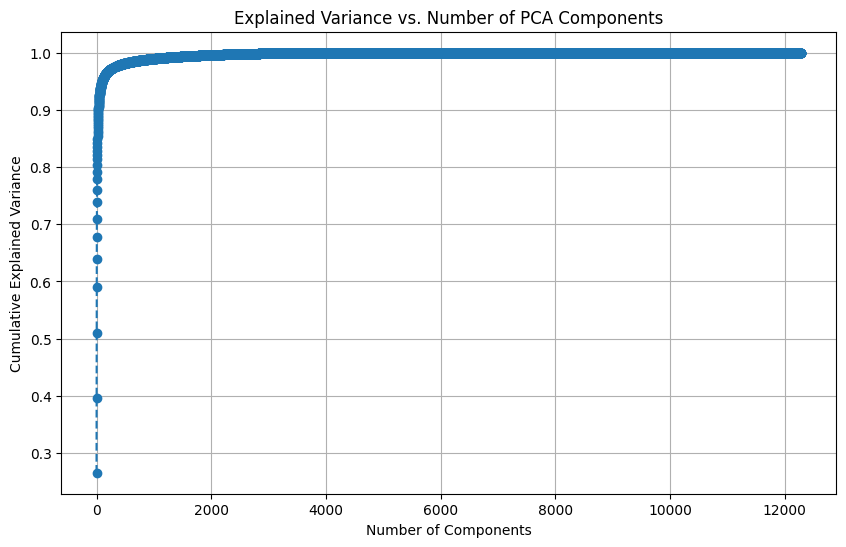

In [4]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA()
pca.fit(images)

cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of PCA Components')
plt.grid(True)
plt.show()

In [5]:
optimal_components = np.argmax(cumulative_explained_variance >= 0.80) + 1
print(f"Number of components that explain 80% of the variance: {optimal_components}")

Number of components that explain 80% of the variance: 12


As 12 qubits capture, around 80% variance, I will progress with using 16 qubits, to capture more variance while making sure that computation does not become too expensive.

**Splitting into test-train dataset**

In [6]:
#Splitting Data into Train/Test dataset
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.25, random_state=42,stratify=labels)
from collections import Counter
print(Counter(y_train),Counter(y_val))

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

pca = PCA(n_components=16)
X_train = pca.fit_transform(X_train)
X_val = pca.transform(X_val)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

Counter({1: 13431, 0: 6568}) Counter({1: 4477, 0: 2190})


# Neural Networks
**MERA cirucit based approach**

The following uses a [MERA](https://arxiv.org/abs/quant-ph/0610099) based circuit for Image Classification,along with a very basic classical Model that has only input and output layers. 

MERA circuits not only improve the model performance, they are also pretty efficient. The same block would take considerably longer to run, with worse results, without the MERA circuit.



In [7]:
import pennylane as qml
import numpy as np
from pennylane import numpy as pnp
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
seed = 12345
np.random.seed(seed=seed)
import torch.nn as nn
import torch.optim as optim
n_qubits = 16
n_layers = 4
import jax
import jax.numpy as jnp
import pennylane as qml
from pennylane import numpy as pnp
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

dev = qml.device("lightning.qubit", wires=n_qubits)

**Defining the Quantum circuit and the MERA block**

In [8]:
import pennylane as qml

def block(weights, wires):
    # Applying layered rotations
    for i, wire in enumerate(wires):
        qml.RX(weights[i], wires=wire)
        qml.RY(weights[i + len(wires)], wires=wire)

    # Applying entanglement 
    for i in range(len(wires) - 1):
        qml.CZ(wires=[wires[i], wires[i + 1]])

    # Ising gates 
    for i in range(len(wires) - 1):
        qml.IsingXX(weights[i + 2 * len(wires)], wires=[wires[i], wires[i + 1]])
        qml.IsingZZ(weights[i + 3 * len(wires)], wires=[wires[i], wires[i + 1]])
        qml.IsingXY(weights[i + 4 * len(wires)], wires=[wires[i], wires[i + 1]])

n_block_wires = 2
n_params_block = 5 * n_block_wires
n_blocks = qml.MERA.get_n_blocks(range(n_qubits), n_block_wires)

@qml.qnode(dev)
def quantum_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.MERA(range(n_qubits), n_block_wires, block, n_params_block, weights)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]
from pennylane import draw




Defining the Hybrid Model, a combination of Qunatum Neural Network, and a classical post processing network

In [9]:
class HybridModel(nn.Module):
    def __init__(self, n_qubits, n_layers, n_classes):
        super().__init__()
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.n_blocks = qml.MERA.get_n_blocks(range(n_qubits), n_block_wires)
        self.q_params = nn.Parameter(torch.randn(self.n_blocks, n_params_block, dtype=torch.float32))
        self.post_net = nn.Sequential(
            nn.Linear(n_qubits, 64),
            nn.ReLU(),
            nn.Linear(64, n_classes)
        )

    def forward(self, x):
        q_out = torch.stack([torch.tensor(quantum_circuit(x_i, self.q_params.detach().numpy()), dtype=x.dtype) for x_i in x])
        return self.post_net(q_out)


In [10]:
model = HybridModel(n_qubits, n_layers,2)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
n_epochs = 7
batch_size = 32
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_val)
y_test_tensor = torch.LongTensor(y_val)
draw(quantum_circuit(X_train_tensor[:batch_size],weights=nn.Parameter(torch.randn(n_blocks, n_params_block, dtype=torch.float32))))



<function pennylane.drawer.draw.draw.<locals>.wrapper>

# Training

In [11]:
for epoch in range(n_epochs):
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train_tensor[i:i+batch_size]
        batch_y = y_train_tensor[i:i+batch_size]

        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 1 == 0:
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.4f}")
model.eval()


Epoch 1/7, Loss: 0.4137
Epoch 2/7, Loss: 0.3913
Epoch 3/7, Loss: 0.3666
Epoch 4/7, Loss: 0.3448
Epoch 5/7, Loss: 0.3249
Epoch 6/7, Loss: 0.3078
Epoch 7/7, Loss: 0.2929


HybridModel(
  (post_net): Sequential(
    (0): Linear(in_features=16, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=2, bias=True)
  )
)

# Validation Inference

For Evaluation I am using a variety of metrics like F1 score,accuracy and AUC-ROC. The primary metric though is the F1 Score, due to high class imbalance. Also False Negatives(that is 1s misclassified as 0s, or defectives classified as non defective) can be harmful for defect detection system, so F1 score is a better metric for evaluation,as it also takes into account false positives and false negatives,

Test Accuracy: 0.9018
F1 Score: 0.9285
AUC-ROC: 0.9467


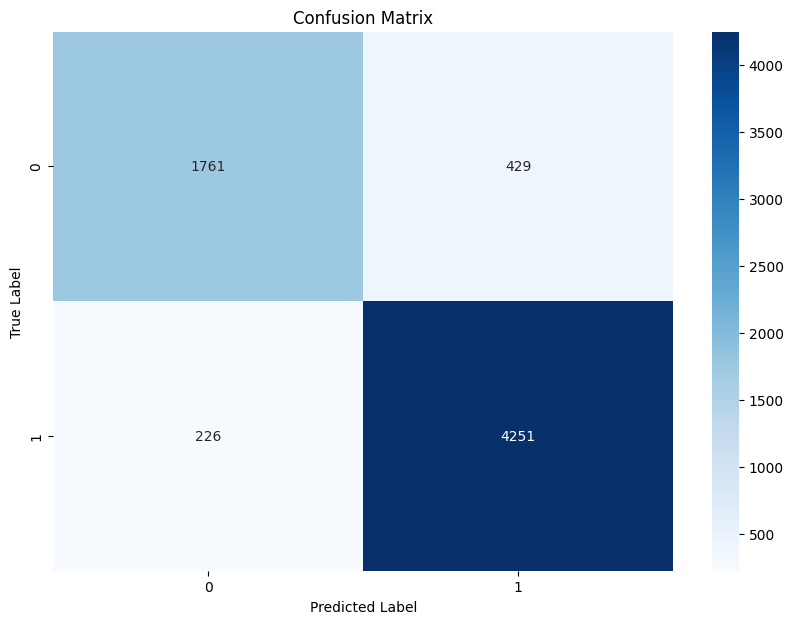

Confusion Matrix:
[[1761  429]
 [ 226 4251]]


In [12]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, predicted = torch.max(test_outputs.data, 1)
    accuracy = accuracy_score(y_val, predicted)
    print(f"Test Accuracy: {accuracy:.4f}")
with torch.no_grad():
    probabilities = torch.softmax(test_outputs, dim=1)
    _, predicted = torch.max(test_outputs.data, 1)
    y_true = y_val
    y_pred = predicted.numpy()
    y_prob = probabilities[:, 1].numpy()
    f1 = f1_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_prob)
    cm = confusion_matrix(y_true, y_pred)
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

print("Confusion Matrix:")
print(cm)

The model performs well on the validation dataset, although the high scores in all three metrics can be an indication of overfitting.

# Test Dataset

In [13]:
test_json_path = os.path.join(test_dir, 'test.json')

with open(test_json_path, 'r') as f:
    test_data = json.load(f)
test_image_paths = []
test_labels = []
for image_path, label in test_data.items():
    if label in [0, 1,2,3,4,5]:  
        full_image_path = os.path.join(test_dir, image_path)
        if os.path.exists(full_image_path): 
            test_image_paths.append(full_image_path)
            if label in [2,3,4,5]:
                test_labels.append(1)
            else:
                test_labels.append(label)

In [14]:
test_images = np.array([load_and_preprocess_image(img_path) for img_path in test_image_paths])
test_labels = np.array(test_labels)
from sklearn.decomposition import PCA
X_test = pca.transform(test_images)
y_test=test_labels
print(Counter(labels))

Counter({1: 17908, 0: 8758})


In [15]:
from sklearn.preprocessing import MinMaxScaler
X_test = scaler.transform(X_test)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, predicted = torch.max(test_outputs.data, 1)
    accuracy = accuracy_score(y_test, predicted)
    print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.7705


F1 Score: 0.8383
AUC-ROC: 0.8568


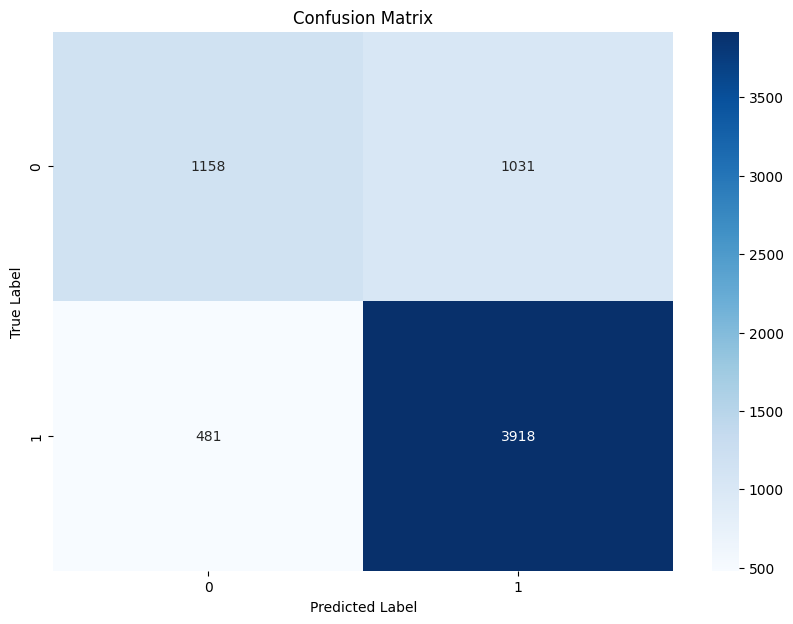

Confusion Matrix:
[[1158 1031]
 [ 481 3918]]


In [16]:
import torch
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

with torch.no_grad():
    probabilities = torch.softmax(test_outputs, dim=1)
    _, predicted = torch.max(test_outputs.data, 1)
    y_true = y_test
    y_pred = predicted.numpy()
    y_prob = probabilities[:, 1].numpy() 
    f1 = f1_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_prob)
    cm = confusion_matrix(y_true, y_pred)
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")

    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

print("Confusion Matrix:")
print(cm)

The accuracy and the F1 score, as we can see is pretty low compared to the validation dataset. This can be termed overfitting. To alleviate it I tried using Data Augmentation techniques, KFold, SMOTE, UnderSampling, though the results did not show any improvement.

To further improve the performance of model, I planned to use Quantum Dropout Technique, but I was unable to get it to work. But Quantum Dropout, like its classical counterpart, could have helped alleviate the overfitting problem.

# **Quonvolutional approach**

Rather than using fully connected neural network as int he above case,we can use a quantum convolution network. This circuit though takes a large time for preprocessing of images,as comapred to the above methoda, however this way we retain more information from the images,as the neither do we have to use PCA to reduce dimensions nor do we have to tune a large number of apramters as in the case of a fully connected neural network.
This approach is followed in the second notebook.